# Dataset Exploration #

Description from PhysioNet:
MIMIC-III is a relational database consisting of 26 tables. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

Charted events such as notes, laboratory tests, and fluid balance are stored in a series of ‘events’ tables. For example the OUTPUTEVENTS table contains all measurements related to output for a given patient, while the LABEVENTS table contains laboratory test results for a patient.

Tables prefixed with ‘D_’ are dictionary tables and provide definitions for identifiers. For example, every row of CHARTEVENTS is associated with a single ITEMID which represents the concept measured, but it does not contain the actual name of the measurement. By joining CHARTEVENTS and D_ITEMS on ITEMID, it is possible to identify the concept represented by a given ITEMID.

Developing the MIMIC data model involved balancing simplicity of interpretation against closeness to ground truth. As such, the model is a reflection of underlying data sources, modified over iterations of the MIMIC database in response to user feedback. Care has been taken to avoid making assumptions about the underlying data when carrying out transformations, so MIMIC-III closely represents the raw hospital data.

Broadly speaking, five tables are used to define and track patient stays: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS. Another five tables are dictionaries for cross-referencing codes against their respective definitions: D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS. The remaining tables contain data associated with patient care, such as physiological measurements, caregiver observations, and billing information.

In some cases it would be possible to merge tables—for example, the D_ICD_PROCEDURES and CPTEVENTS tables both contain detail relating to procedures and could be combined—but our approach is to keep the tables independent for clarity, since the data sources are significantly different. Rather than combining the tables within MIMIC data model, we suggest researchers develop database views and transforms as appropriate.

In [1]:
# Todo: create virtualenv with PySyft and SyferText dependencies
import numpy as np
import pandas as pd
from subprocess import check_output
# list the files contained in our dataset
print(check_output(["ls","mimiciii1.4"]).decode("utf-8"))

ADMISSIONS.csv.gz
CALLOUT.csv.gz
CAREGIVERS.csv.gz
CHARTEVENTS.csv.gz
CPTEVENTS.csv.gz
DATETIMEEVENTS.csv.gz
DIAGNOSES_ICD.csv.gz
DRGCODES.csv.gz
D_CPT.csv.gz
D_ICD_DIAGNOSES.csv.gz
D_ICD_PROCEDURES.csv.gz
D_ITEMS.csv.gz
D_LABITEMS.csv.gz
ICUSTAYS.csv.gz
INPUTEVENTS_CV.csv.gz
INPUTEVENTS_MV.csv.gz
LABEVENTS.csv.gz
LICENSE.txt
MICROBIOLOGYEVENTS.csv.gz
NOTEEVENTS.csv.gz
OUTPUTEVENTS.csv.gz
PATIENTS.csv.gz
PRESCRIPTIONS.csv.gz
PROCEDUREEVENTS_MV.csv.gz
PROCEDURES_ICD.csv.gz
README.md
SERVICES.csv.gz
SHA256SUMS.txt
TRANSFERS.csv.gz
index.html



In [2]:
d_icd_diagnoses_df = pd.read_csv('mimiciii1.4/D_ICD_DIAGNOSES.csv.gz',compression='gzip')
patients_df = pd.read_csv('mimiciii1.4/PATIENTS.csv.gz',compression='gzip')
admissions_df = pd.read_csv('mimiciii1.4/ADMISSIONS.csv.gz',compression='gzip')
diagnoses_icd_df = pd.read_csv('mimiciii1.4/DIAGNOSES_ICD.csv.gz',compression='gzip')

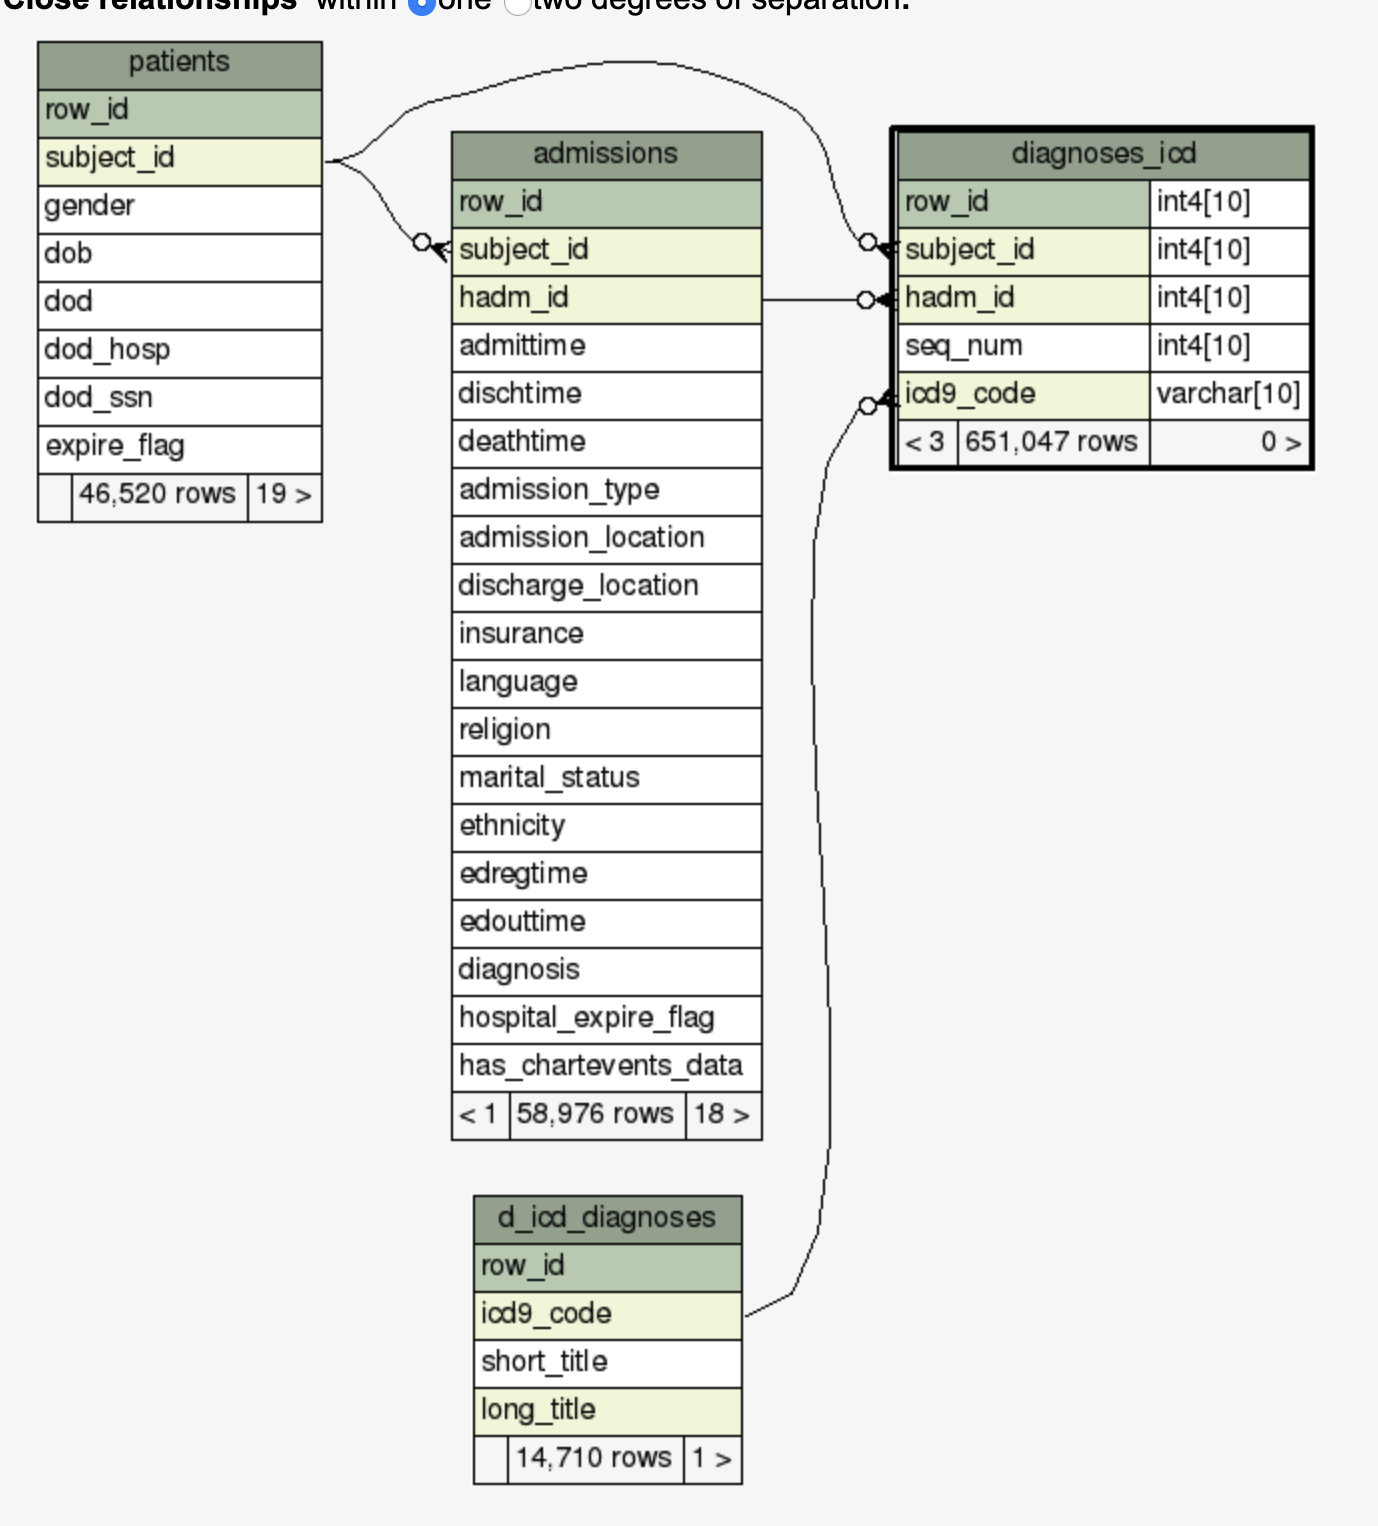

In [3]:
# "All ICD codes in MIMIC-III are ICD-9 based."
diagnoses_icd_df.info()
diagnoses_icd_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM
count,651047.000000,651047.000000,651047.000000,651000.000000
mean,325524.000000,38971.159758,150017.744819,7.913836
std,187941.224689,29372.198841,28878.068648,6.072633
min,1.000000,2.000000,100001.000000,1.000000
25%,162762.500000,14562.500000,125028.000000,3.000000
50%,325524.000000,28671.000000,150140.000000,6.000000
75%,488285.500000,63715.000000,174978.000000,11.000000
max,651047.000000,99999.000000,199999.000000,39.000000


In [4]:
diagnoses_icd_df.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [5]:
# test the theory that higher HADM_ID refers to later admissions chronologically
print('number of unique patients: ',admissions_df['SUBJECT_ID'].nunique())
print('average number of visits',admissions_df['SUBJECT_ID'].value_counts().mean())

# most people only visited once, examine how many visited at least twice
# need refactoring later
s = admissions_df['SUBJECT_ID'].value_counts()
s = s.where(s >= 2).dropna()
print('number of patients with at least two visits',len(s))

number of unique patients:  46520
average number of visits 1.267755803955288
number of patients with at least two visits 7537


In [6]:
# to retain those patients with more than one visit and group them together
admissions_df = admissions_df.groupby('SUBJECT_ID').filter(lambda groupby_obj: len(groupby_obj) >= 2)
admissions_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
12,33,34,115799,2186-07-18 16:46:00,2186-07-20 16:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1
13,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1
15,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
16,37,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,2131-05-12 17:26:00,2131-05-12 22:17:00,CHEST PAIN/SHORTNESS OF BREATH,0,1
17,38,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,LONG TERM CARE HOSPITAL,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,VENTRAL HERNIA/SDA,0,1
22,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1
23,457,357,145674,2198-08-02 04:49:00,2198-10-26 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-08-02 02:03:00,2198-08-02 05:37:00,SEIZURE,0,1
24,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1


In [7]:
# construct dictionary mapping: patient => number of visits/admissions
def construct_patients_visits_dict(admissions_df):
    return admissions_df.groupby('SUBJECT_ID').size().to_dict()
patients_visits_dict = construct_patients_visits_dict(admissions_df)
# get the max key to know how much to pad the multivariate matrix later
max_key = max(patients_visits_dict, key=patients_visits_dict.get)
print('SUBJECT_ID',max_key,'was admitted',patients_visits_dict[max_key],'times')
print('total number of patients',len(patients_visits_dict))

SUBJECT_ID 13033 was admitted 42 times
total number of patients 7537


In [8]:
# Todo: The dataset is a LOT smaller than that mentioned is proposed in MetaPred
# so, try self supervision with dfencoder to construct more rows with noise for these patients
# https://towardsdatascience.com/how-to-apply-self-supervision-to-tabular-data-introducing-dfencoder-eec21c4afaef

In [9]:
# ICD-9 code are objects
# look at first 10 ICD-9 code and look up what they mean in dictionary
for row in diagnoses_icd_df.head(10).itertuples():
    print('ICD9_Code',row[5],d_icd_diagnoses_df.loc[d_icd_diagnoses_df['ICD9_CODE']==row[5]]['SHORT_TITLE'].values)

ICD9_Code 40301 ['Mal hyp kid w cr kid V']
ICD9_Code 486 ['Pneumonia, organism NOS']
ICD9_Code 58281 ['Chr nephritis in oth dis']
ICD9_Code 5855 ['Chron kidney dis stage V']
ICD9_Code 4254 ['Prim cardiomyopathy NEC']
ICD9_Code 2762 ['Acidosis']
ICD9_Code 7100 ['Syst lupus erythematosus']
ICD9_Code 2767 ['Hyperpotassemia']
ICD9_Code 7243 ['Sciatica']
ICD9_Code 45829 ['Iatrogenc hypotnsion NEC']


In [10]:
# 1. there are multiple icd codes per admission or visit, we form a list per visit
# 2. concatenate each list of codes from an individual visit for a patient
# 3. map down to three digit
patient_list = admissions_df['SUBJECT_ID'].unique()
def patient_icds_per_visit():
    visit_list = []
    master_icd_list = []
    for patient in patient_list:
        patient_df = admissions_df.loc[admissions_df['SUBJECT_ID']==patient]
        # note that this is sorted by admit time already
        # print(patient_df)
        
        for _,visit in patient_df.iterrows():
            visit_df = diagnoses_icd_df.loc[diagnoses_icd_df['HADM_ID']==visit['HADM_ID']]
            visit_df = visit_df.dropna()
            icd_code_list = []
            
            for _,diagnoses in visit_df.iterrows():
                # add icd code mapped to first three digits
                code = diagnoses['ICD9_CODE'][:3]
                icd_code_list.append(code)
                if code not in master_icd_list:
                    master_icd_list.append(code)
                
            visit_list.append([patient, icd_code_list])
        
    return visit_list, master_icd_list
        
visit_list, master_icd_list = patient_icds_per_visit()
patient_history_df = pd.DataFrame(visit_list)
patient_history_df.columns = ['SUBJECT_ID','ICD_9_PER_VISIT']
patient_history_df.head()

,SUBJECT_ID,ICD_9_PER_VISIT
0,23,"[414, 411, 424, V45, 272, 401, 600, 389]"
1,23,"[225, 348, 780, 424, 401, 272, 272, V45, V45, ..."
2,34,"[410, 428, 425, 427, 997, 426, 414, E87]"
3,34,"[427, 428, 426, 414, V58, 428, 244, 365]"
4,36,"[414, 411, 496, 401, 305, 530, 600, V10, 596]"


In [11]:
# master_icd_list = [item for innerlist in master_icd_list for item in innerlist] # flatten
# master_icd_list = list(set(master_icd_list)) # get rid of duplicates
master_icd_list.sort()
vocab_size = len(master_icd_list)
print('the length of vocab i.e. num of unique ICD-codes: ',vocab_size)
# print(master_icd_list)

the length of vocab i.e. num of unique ICD-codes:  856


In [12]:
# TODO: Dictionary is obsolete because we are using scikitlearn
# construct dictionary mapping: icd => integer. 
# used to produce multilabel encodings
def construct_icd_int_dict(l):
    return {code: i for i, code in enumerate(l)} 

master_icd_dict = construct_icd_int_dict(master_icd_list)
# master_icd_dict

In [24]:
import torch
from sklearn.preprocessing import MultiLabelBinarizer
# create multivariate matrix t x |C| for each patient 
# where t=num of visits, |C|=size of vocab (number of ICD-codes we have)
# in other words, each row t is a vector x_t ∈ {0,1}|C|


def multivariate_time_matrix(patients_visits_dict, patient_history_df, master_icd_list):
    mlb = MultiLabelBinarizer() # initialize encoder
    mlb.fit([master_icd_list]) # fit the label sets binarizer, storing classes_
    # print(mlb.classes_)
    
    # some useful dimensions
    num_patients = len(patients_visits_dict)
    max_num_visit = max(patients_visits_dict.values())
    vocab_size = len(master_icd_list)
    
    # make master numpy array
    array = np.zeros(shape=(num_patients, max_num_visit, vocab_size))
    patients_visits_tensor = torch.zeros(len(patients_visits_dict))
    for i,patient in enumerate(patients_visits_dict):
        
        # extract icd code from each patient
        patient_df = patient_history_df.loc[patient_history_df['SUBJECT_ID']==patient]
        patient_code_list = patient_df['ICD_9_PER_VISIT'].tolist()
        assert patients_visits_dict[patient] == len(patient_code_list)
        
        # create multilabel binary numpy array
        patient_multilabel_array = mlb.transform(patient_code_list)
        # print(patient_code_list)
        # print(patient_multilabel_array)
        
        # pad entry and append to master array
        padded_patient_array = np.zeros(shape=(max_num_visit, vocab_size))
        padded_patient_array[:patient_multilabel_array.shape[0],:] = patient_multilabel_array
        
        patients_visits_tensor[i] = patient_multilabel_array.shape[0]
        assert padded_patient_array.shape == (42, 856)
        
        array[i] = padded_patient_array
    
    # convert to pytorch tensor
    tensor = torch.from_numpy(array)
    assert tensor.shape == (num_patients, max_num_visit, vocab_size)
    
    return tensor
    # return tensor of dimension (total number of patients x max visits (42 in our case) x size of vocab)

tensor = multivariate_time_matrix(patients_visits_dict, patient_history_df, master_icd_list)
print(tensor.size())

torch.Size([7537, 42, 856])


In [25]:
# save tensor
torch.save(tensor,'multivariate_time_matrix.pt')

In [27]:
torch.save(patients_visits_tensor,'patients_visits_tensor.pt')